In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time

In [23]:
data = pd.read_csv('ps6.csv').drop('Unnamed: 0', axis=1)
# data is in y x x x x .. form, need to change "v1" to y
data.columns = ['y'] + ['x' + str(i) for i in range(data.shape[1]-1)]

X = np.array(data.drop('y', axis=1))
y = np.array(data['y'])

data.head()

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x988,x989,x990,x991,x992,x993,x994,x995,x996,x997
0,46.262314,-0.896915,-0.459789,0.466200,-0.847244,-1.892349,-0.954353,-2.138476,-0.300585,0.640845,...,0.446921,0.742868,1.277909,-1.061503,0.837248,1.224842,-0.084621,-0.166817,-0.334167,-0.121967
1,-96.648999,0.184849,0.617926,0.954666,0.070429,1.292804,-1.408150,-0.900792,0.058544,-1.601378,...,-0.123327,0.202375,-1.390600,0.499964,1.069710,-1.608390,-1.147154,1.184872,0.928585,-0.609970
2,-22.650160,1.587845,-0.720422,-0.947206,1.581195,-0.618254,0.541784,0.149915,0.501346,-0.777815,...,-0.062811,0.456465,0.096263,0.221467,-1.235428,0.736869,-1.001701,0.581641,1.941146,0.416230
3,114.378196,-1.130376,-0.583512,0.038563,0.020598,1.040938,-1.243239,1.126413,-0.109977,-1.647392,...,0.200268,1.511462,0.327510,0.352731,0.823882,0.579083,-0.903109,-0.316210,0.296681,-0.165842
4,3.446211,-0.080252,0.216325,-0.830882,-0.123371,1.175879,-2.035629,1.249366,-1.309643,0.154266,...,0.158417,-0.174594,-0.302418,-0.534555,-0.042618,0.451430,-1.276987,2.214985,-0.456991,-0.279551


# Problem 1
## 1
### A
Let $\vert\vert z_1 \in \mathbb{R}^{m_1}$ and let $z_2 \in \mathbb{R}^{m_2}$. Moreover, let $z = (z_1, z_2)$. Then, we have that 
$\begin{align}
\vert\vert z_1 \vert\vert_2^2 &= \sum_{i=1}^{m_1} z_{1, i}^2 \\
\vert\vert z_2 \vert\vert_2^2 &= \sum_{i=1}^{m_2} z_{2, i}^2 \\
\implies \vert\vert z_1 \vert\vert_2^2 + \vert\vert z_2 \vert\vert_2^2 & = \sum_{i=1}^{m_1} z_{1, i}^2 + \sum_{i=1}^{m_2} z_{2, i}^2 \\
& = \sum_{i = 1}^{m_1} z_i^2 + \sum_{i = m_1+1}^{m_1+m_2} z_i^2 \\
& = \sum_{i=1}^{m_1+m_2} z^2_i \\
\implies \vert\vert z_1 \vert\vert_2^2 + \vert\vert z_2 \vert\vert^2_2 & = \sum_{i=1}^{m_1+m_2} z^2_i
\end{align}$

### B


## 2
### A
This is a constrained optimization problem where $f$ is the objective function that we are attempting to minimize. Our constraint is that $\beta_j \neq \tilde{beta}_l$ for all $j \neq l$. This is a non-linear constraint. In words, this constraint means that for a given index $j$ from 1 to $p$, $\beta_j$ cannot be equal to any other $\beta_l$ for $l \neq j$, meaning that only the $j-th$ parameter of $\beta$ can vary in order to minimize the objective function while everything else is held constant.

Obviously, since this program constrains every parameter individually, this allows us to minimize the objective function parameter by parameter, varying only one parameter at a time. Hence, this makes sense in the context of regularization. 

### B

In [3]:
def soft_thresholding(a, b):
    """Apply the soft-thresholding function."""
    return np.sign(a) * np.maximum(np.abs(a) - b, 0)

def calculate_beta_j_star(y, X, lambda_, alpha, beta_tilde, j):
    """
    Calculate the optimal beta_j_star for a given j, holding other coefficients at their candidate values.
    
    :param y: Dependent variable vector.
    :param X: Independent variable matrix (standardized).
    :param lambda_: Regularization parameter lambda.
    :param alpha: Additional parameter alpha.
    :param beta_tilde: Candidate values for beta coefficients.
    :param j: Index of the coefficient to optimize.
    :return: Optimal value of beta_j_star.
    """
    n = X.shape[0]  # Number of rows in X
    
    X_j = X[:, j]  
    beta_tilde_j = np.copy(beta_tilde)  
    beta_tilde_j[j] = 0  
    residual = y - (beta_tilde[0] + X @ beta_tilde_j)  # Calculate residual
    
    numerator = X_j.T @ residual
    
    beta_j_star = soft_thresholding(numerator, alpha * lambda_) / n
    
    return beta_j_star

### C

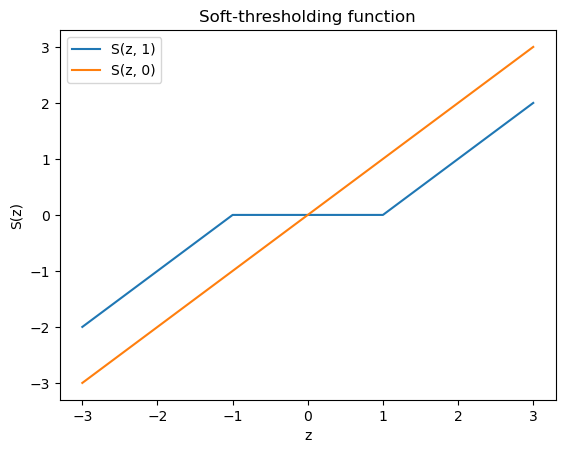

In [4]:
# plot soft-thresholding function
zs = np.linspace(-3, 3, 100)

first_values = [soft_thresholding(z, 1) for z in zs]
second_values = [soft_thresholding(z, 0) for z in zs]

plt.plot(zs, first_values, label='S(z, 1)')
plt.plot(zs, second_values, label='S(z, 0)')
plt.legend()
plt.title('Soft-thresholding function')
plt.xlabel('z')
plt.ylabel('S(z)')
plt.show()

## 3 \& 4

In [5]:
def normalize_X(X):
    """Normalize the feature matrix X (excluding the intercept if present)."""
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    return X_normalized, mean_X, std_X

def calculate_residual(y, X, beta, j):
    """Calculate residual excluding contribution from j-th feature."""
    return y - X @ beta + X[:, j] * beta[j]

def update_beta_j(y, X, beta, lambda_, n, j):
    """Update rule for beta_j using soft-thresholding."""
    if j == 0:  
        return X[:, j].T @ (y - X @ beta + X[:, j] * beta[j]) / n
    else:
        residual = calculate_residual(y, X, beta, j)
        return soft_thresholding(X[:, j].T @ residual, lambda_) / (X[:, j].T @ X[:, j])

def coordinate_descent(y, X, lambda_, epsilon=0.1, active_set_strategy=True):
    n, p = X.shape
    beta = np.zeros(p)
    beta_prev = np.copy(beta)
    indices = np.arange(p)
    
    X, mean_X, std_X = normalize_X(X)
    X = np.hstack((np.ones((n, 1)), X))  
    
    converged = False
    while not converged:
        if active_set_strategy:
            active_indices = indices[beta != 0]
            cycling_indices = active_indices if active_indices.size > 0 else indices
        else:
            cycling_indices = indices
        
        for j in cycling_indices:
            beta[j] = update_beta_j(y, X, beta, lambda_, n, j)
        
        objective_diff = np.linalg.norm(beta - beta_prev)
        if objective_diff < epsilon:
            if active_set_strategy and (cycling_indices.size < p):
                active_set_strategy = False
            else:
                converged = True
        else:
            beta_prev = np.copy(beta)
    
    return beta

## 5

In [11]:
scaler = StandardScaler()

X_standardized = scaler.fit_transform(X)

l = 100
delta = 0.0001

lambda_max = np.max(np.abs(X_standardized.T @ y)) / np.sqrt(len(y))

lambda_min = lambda_max * delta

log_lambda_sequence = np.linspace(np.log(lambda_min), np.log(lambda_max), l)
lambda_sequence = np.exp(log_lambda_sequence)

lambda_sequence

array([4.45879351e-02, 4.89352037e-02, 5.37063257e-02, 5.89426261e-02,
       6.46894594e-02, 7.09966019e-02, 7.79186829e-02, 8.55156583e-02,
       9.38533294e-02, 1.03003913e-01, 1.13046668e-01, 1.24068578e-01,
       1.36165111e-01, 1.49441042e-01, 1.64011359e-01, 1.80002264e-01,
       1.97552262e-01, 2.16813364e-01, 2.37952399e-01, 2.61152464e-01,
       2.86614507e-01, 3.14559068e-01, 3.45228188e-01, 3.78887511e-01,
       4.15828575e-01, 4.56371348e-01, 5.00866991e-01, 5.49700904e-01,
       6.03296064e-01, 6.62116685e-01, 7.26672245e-01, 7.97521891e-01,
       8.75279291e-01, 9.60617942e-01, 1.05427700e+00, 1.15706771e+00,
       1.26988038e+00, 1.39369215e+00, 1.52957542e+00, 1.67870713e+00,
       1.84237901e+00, 2.02200869e+00, 2.21915204e+00, 2.43551662e+00,
       2.67297649e+00, 2.93358839e+00, 3.21960964e+00, 3.53351760e+00,
       3.87803121e+00, 4.25613446e+00, 4.67110232e+00, 5.12652903e+00,
       5.62635928e+00, 6.17492237e+00, 6.77696967e+00, 7.43771585e+00,
      

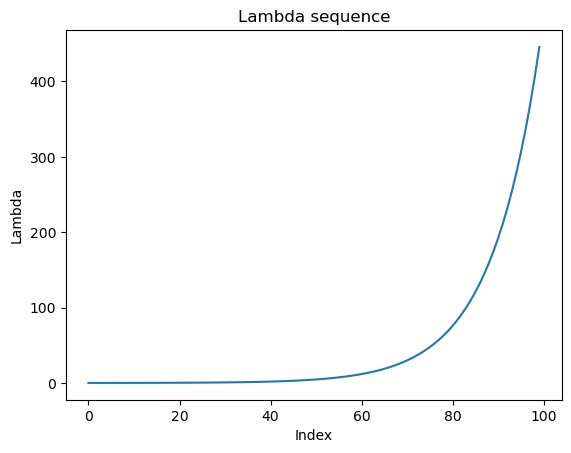

In [12]:
# Graph the lambda sequence, its just kind of hard to look at the array
plt.plot(lambda_sequence)
plt.title('Lambda sequence')
plt.xlabel('Index')
plt.ylabel('Lambda')
plt.show()

## 6
Here is the most updated code for every part of the problem:

In [26]:
def soft_thresholding(x, lambda_val):
    return np.sign(x) * max(abs(x) - lambda_val, 0)

def update_beta(X, y, beta, lambda_val, j):
    n = X.shape[0]
    non_j_columns = [i for i in range(X.shape[1]) if i != j]
    residual = y - X[:, non_j_columns] @ beta[non_j_columns]
    rho = X[:, j].T @ residual / n
    beta_j_new = soft_thresholding(rho, lambda_val)
    return beta_j_new

def cyclic_coordinate_descent(X, y, lambda_val, epsilon=0.1, active_set=False):
    n, p = X.shape
    beta = np.zeros(p)
    converge = False
    while not converge:
        beta_old = beta.copy()
        for j in range(p):
            beta[j] = update_beta(X, y, beta, lambda_val, j)
        
        if active_set:
            non_zero_parameters = np.where(beta != 0)[0]
            for j in non_zero_parameters:
                beta[j] = update_beta(X, y, beta, lambda_val, j)
        
        if np.linalg.norm(beta - beta_old, ord=2) < epsilon:
            converge = True
    return beta

## 7

# Problem 2

In [6]:
X = data.drop('y', axis=1).values
y = data['y'].values

ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

# LEFT HAND SIDE
print('LEFT HAND SIDE')
ridge_coef_left  = np.linalg.inv(X.T @ X + np.eye(X.shape[1])) @ X.T @ y

# RIGHT HAND SIDE
print('RIGHT HAND SIDE')
ridge_coef_right = X.T @ np.linalg.inv(X @ X.T + np.eye(X.shape[0])) @ y

# Print the greatest difference between the two 
print('The greatest difference between the two is:', np.max(np.abs(ridge_coef_left - ridge_coef_right)))

LEFT HAND SIDE
RIGHT HAND SIDE
The greatest difference between the two is: 7.508882404749784e-12


This difference is really small $(10^{-12})$, so I am comfortable saying that these results are numerically equal. 

I think preference between the two methods would depend on the context of the problem. If the problem is a simple one (i.e., $p < n$), then I would prefer the first method since it inverts a smaller matrix which is more efficient. However, if the problem is more complex (i.e., $n < p$), then I would prefer the second method because it should be more computationally efficient as we are inverting a smaller matrix.

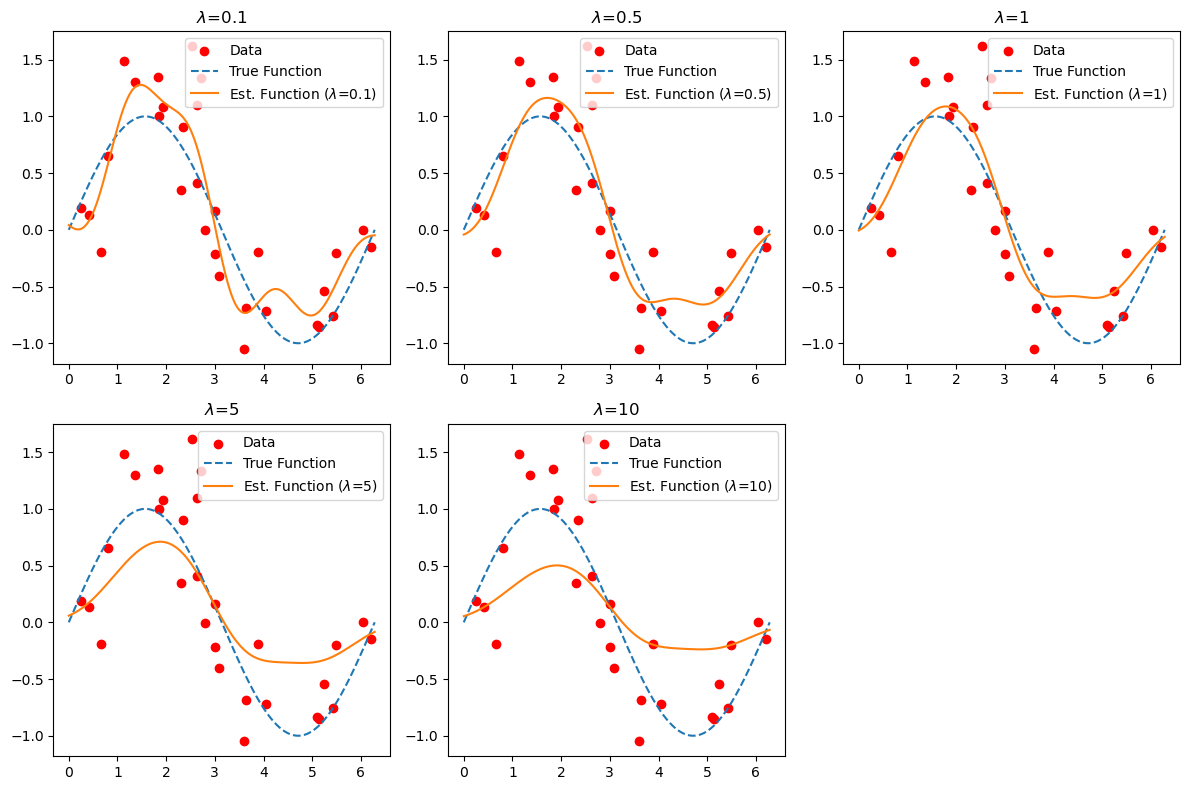

In [7]:
np.random.seed(428)

# DGP from pset 1
def generate_data(n=30):
    x = np.random.uniform(0, 2*np.pi, n)
    y = np.sin(x) + np.random.normal(0, np.sqrt(0.2), n)
    return x, y

x, y = generate_data()

X = x.reshape(-1, 1)

# True function
x_plot = np.linspace(0, 2*np.pi, 1000)
y_true = np.sin(x_plot)

# Lambda values
lambdas = [0.1, 0.5, 1, 5, 10]

# Plot
plt.figure(figsize=(12, 8))
for i, lmbda in enumerate(lambdas):
   
    model = KernelRidge(alpha=lmbda, kernel='rbf', gamma=1)
    model.fit(X, y)
    
    
    y_pred = model.predict(x_plot.reshape(-1, 1))

    plt.subplot(2, 3, i+1)
    plt.scatter(x, y, color='red', label='Data')
    plt.plot(x_plot, y_true, label='True Function', linestyle='--')
    plt.plot(x_plot, y_pred, label=f'Est. Function ($\lambda$={lmbda})')
    plt.legend()
    plt.title(f'$\lambda$={lmbda}')

plt.tight_layout()
plt.show()


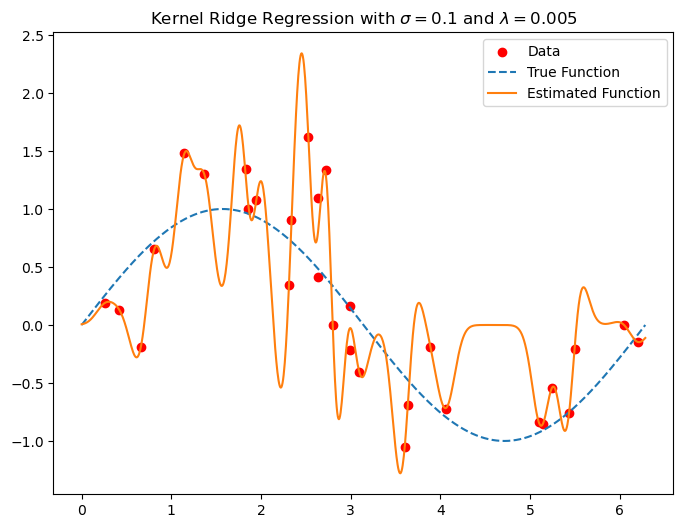

In [8]:
# new parameters
sigma = 0.1
gamma = 1 / (2 * sigma ** 2)
lambda_ = 0.005

model = KernelRidge(alpha=lambda_, kernel='rbf', gamma=gamma)
model.fit(X, y)

y_pred = model.predict(x_plot.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='red', label='Data')
plt.plot(x_plot, y_true, label='True Function', linestyle='--')
plt.plot(x_plot, y_pred, label='Estimated Function')
plt.legend()
plt.title(f'Kernel Ridge Regression with $\sigma={sigma}$ and $\lambda={lambda_}$')
plt.show()